In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import torch.quantization
from tqdm import tqdm 
from torch.nn.utils import prune

# Pre-defined Functions


## 1. Ploting the loss function 
over the trian and test sets to check the overfitting

In [2]:
def plot_loss(train_losses, test_losses, subtitle="", model_name=""):

    # Create the figure and axis objects
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the training and testing loss
    ax.plot(train_losses, label='Training Loss', color='blue', linewidth=1.5)
    ax.plot(test_losses, label='Testing Loss', color='orange', linewidth=1.5)

    # Set title and labels with appropriate font sizes
    ax.set_title(f"Loss Over Epochs -- {model_name}", fontsize=18, pad=20)
    ax.set_xlabel('Epoch', fontsize=16)
    ax.set_ylabel('Loss', fontsize=16)

    # Add the subtitle if provided
    if subtitle:
        ax.text(0.5, 1.03, subtitle, fontsize=12, ha='center', va='center', transform=ax.transAxes)

    # Set the legend with a modest font size and without a frame
    ax.legend(fontsize=14, frameon=False)

    # Add grid lines for better readability and aesthetics
    ax.grid(True, linestyle='--', alpha=0.5, which='major')

    # Improve layout to avoid cutting off information and to adjust padding
    plt.tight_layout(pad=1.5)

    # Show the plot
    plt.show()


## 2. Plot the inference time 

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_time(T, subtitle="", model_name=""):

    # Create the figure and axis objects
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the histogram
    n, bins, patches = ax.hist(T, bins=50, density=False, alpha=0.7, color='blue', edgecolor='black', label='Inference Time')

    # Find the peak value and its corresponding bin
    peak_value = np.max(n)
    peak_index = np.argmax(n)
    peak_bin_center = (bins[peak_index] + bins[peak_index + 1]) / 2

    # Plot a vertical line at the peak value
    ax.axvline(x=peak_bin_center, color='red', linestyle='--', linewidth=2, label=f'Peak Value: {peak_bin_center:.5f}s')

    # Set title and labels with appropriate font sizes
    ax.set_title(f'Inference Time Distribution -- {model_name}', fontsize=18, pad=20)
    ax.set_xlabel('Inference Time (s)',fontsize=16)
    ax.set_ylabel('Frequency', fontsize=16)

    # Add the subtitle if provided, adjusting its position to avoid overlap
    if subtitle:
        ax.text(0.5, 1.03, subtitle, fontsize=12, ha='center', va='center', transform=ax.transAxes)

    # Set the legend with a modest font size and without a frame
    ax.legend(fontsize=14, frameon=False)

    # Add grid lines for better readability
    ax.grid(True, linestyle='--', alpha=0.5, which='major')

    # Improve layout to avoid cutting off information and to adjust padding
    plt.tight_layout(pad=1.5)

    # Show the plot
    plt.show()



In [4]:
def train_model_qat(model, train_loader, test_loader, lr, num_epochs):
    model.train()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    train_losses = []
    test_losses = []
    timing = {'quant_time': 0, 'fc_time': 0, 'dequant_time': 0}

    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        epoch_train_loss = 0
        epoch_test_loss = 0

        # Training loop
        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            optimizer.zero_grad()
            outputs, quant_time, fc_time, dequant_time = model(inputs)
            
            # Accumulate the timing information
            timing['quant_time'] += quant_time
            timing['fc_time'] += fc_time
            timing['dequant_time'] += dequant_time

            # Compute training loss
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
            
        # Compute average training loss
        train_losses.append(epoch_train_loss / len(train_loader))
        # print(f"Epoch {epoch+1}, Train Loss: {epoch_train_loss / len(train_loader)}")

        # Evaluation loop on test set
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc="Testing", leave=False):
                outputs, _, _, _ = model(inputs)
                test_loss = criterion(outputs.squeeze(), labels.float())
                epoch_test_loss += test_loss.item()
        
        # Compute average test loss
        test_losses.append(epoch_test_loss / len(test_loader))
        # print(f"Epoch {epoch+1}, Test Loss: {epoch_test_loss / len(test_loader)}")

        model.train()  # Set model back to training mode

    return train_losses, test_losses, timing, model        

In [5]:
import torch
import numpy as np
import time

def evaluate_model(model, test_loader):
    model.eval()
    y_pre = []
    T = []
    final_accuracy = 0  # Initialize variable to store final accuracy

    for _ in range(200):
        times = 0
        with torch.no_grad():
            correct = 0
            total = 0
            for inputs, labels in test_loader:
                stt = time.time()
                outputs, _ = model(inputs)
                ent = time.time()
                times += ent - stt
                predicted = (outputs.squeeze() > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                y_pre.append(predicted.numpy())  # Append numpy array of predictions
            T.append(times)
            final_accuracy = correct / total  # Update final accuracy after each epoch

    T = np.array(T)
    print(f'Accuracy: {final_accuracy}')
    print(f'Predict time: {times}')

    return T, final_accuracy


# Load the Data

In [6]:
batch = 1024

In [7]:
df = pd.read_parquet('/workspaces/Acc-Higgs-HLS4ML/ML model/df.parquet')
X = pd.read_parquet('/workspaces/Acc-Higgs-HLS4ML/ML model/x.parquet').values  
df['proc'] = df['proc'].apply(lambda x: 1 if x != 0 else 0)
y = df['proc'].values  

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=batch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch, shuffle=False)


In [8]:
num_epochs = 40
layers = [1024, 512, 128]
lr = 0.001

# original model

In [9]:
class BinaryClassificationModel(nn.Module):
    def __init__(self):
        super(BinaryClassificationModel, self).__init__()
        self.layer0 = nn.Linear(X.shape[1], layers[0])
        self.layer1 = nn.Linear(layers[0], layers[1])
        self.layer2 = nn.Linear(layers[1], layers[2])
        self.layer3 = nn.Linear(layers[2], 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        timings = {}

        start_time = time.time()
        x = torch.relu(self.layer0(x))
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        timings['fc_time'] = time.time() - start_time

        x = self.sigmoid(self.layer3(x))
        
        return x, timings['fc_time']
model = BinaryClassificationModel()

In [10]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_model(model, train_loader, test_loader, lr, num_epochs):
    model.train()
    criterion = nn.BCELoss()  # Combines Sigmoid + BCELoss
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    train_losses = []
    test_losses = []
    timing = {'fc_time': 0}

    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        epoch_train_loss = 0
        epoch_test_loss = 0

        # Training loop
        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            optimizer.zero_grad()
            outputs, fc_time = model(inputs)
            timing['fc_time'] += fc_time
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        # Compute average training loss
        train_losses.append(epoch_train_loss / len(train_loader))

        # Validation loop (test set)
        model.eval()
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc="Testing", leave=False):
                outputs, _ = model(inputs)
                loss = criterion(outputs.squeeze(), labels.float())
                epoch_test_loss += loss.item()

        # Compute average test loss
        test_losses.append(epoch_test_loss / len(test_loader))

        model.train()

    return train_losses, test_losses, timing, model


In [11]:
# Train the model
train_losses, test_losses, timing, model = train_model(model, train_loader, test_loader, lr, num_epochs)


Epochs: 100%|██████████| 100/100 [05:40<00:00,  3.41s/it]


In [12]:
# save the model
torch.save(model.state_dict(), 'model.pth')

In [13]:
moddel = BinaryClassificationModel()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [14]:
model

BinaryClassificationModel(
  (layer0): Linear(in_features=140, out_features=1024, bias=True)
  (layer1): Linear(in_features=1024, out_features=512, bias=True)
  (layer2): Linear(in_features=512, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [15]:
np.save("train_losses.npy", train_losses)
np.save("test_losses.npy", test_losses)

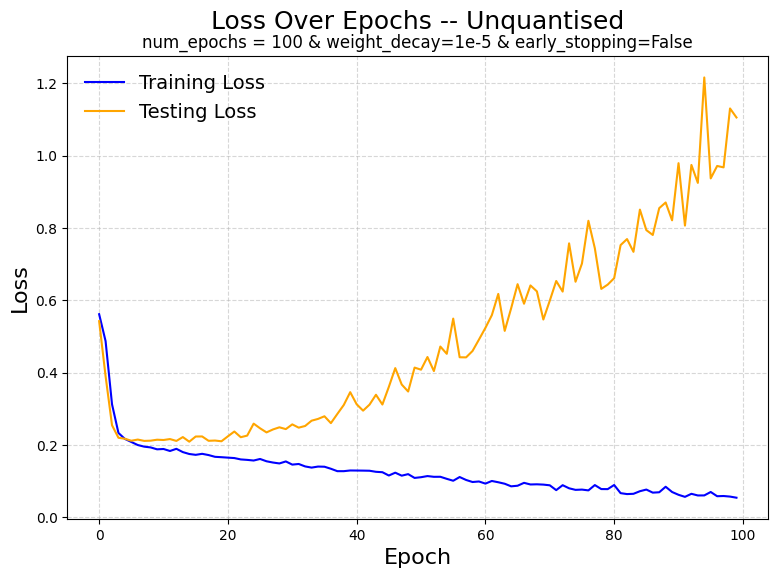

In [19]:
plot_loss(train_losses, test_losses, subtitle='num_epochs = 100 & weight_decay=1e-5 & early_stopping=False', model_name= "Unquantised")

In [16]:
model.eval()
y_pre = []
T = []
for _ in range(200):
    times = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            stt= time.time()
            outputs, _ = model(inputs)
            ent = time.time()
            times+=ent-stt
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pre.append(predicted)
        T.append(times)
T= np.array(T)
accuracy0 = correct / total

print(f'Accuracy: {accuracy0}')
print(f'Predict time: {times}')

Accuracy: 0.908
Predict time: 0.20012450218200684


In [17]:
# save the T
np.save("T.npy", T)

In [18]:
# load the data for inference times
T = np.load("T.npy")

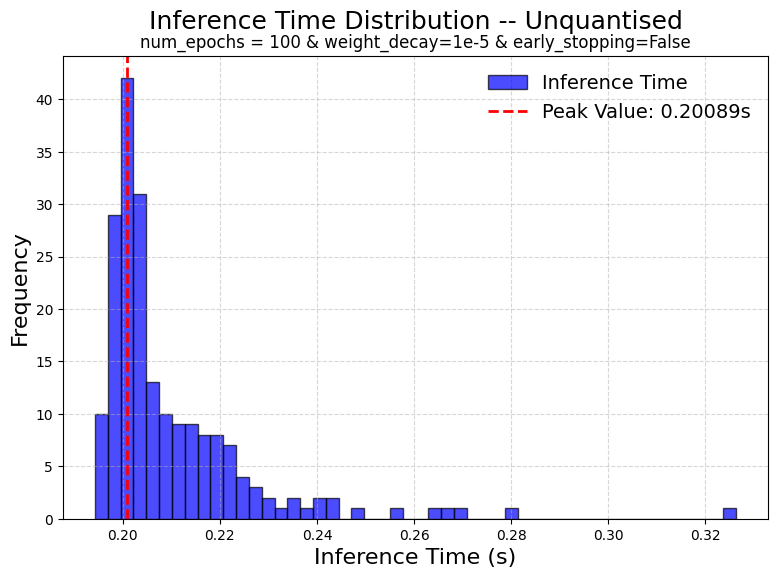

In [22]:
plot_time(T, subtitle='num_epochs = 100 & weight_decay=1e-5 & early_stopping=False', model_name="Unquantised")

### Lower thr weight decay tp 1e-3

In [ ]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_model1(model, train_loader, test_loader, lr, num_epochs):
    model.train()
    criterion = nn.BCELoss()  # Combines Sigmoid + BCELoss
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
    train_losses = []
    test_losses = []
    timing = {'fc_time': 0}

    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        epoch_train_loss = 0
        epoch_test_loss = 0

        # Training loop
        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            optimizer.zero_grad()
            outputs, fc_time = model(inputs)
            timing['fc_time'] += fc_time
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        # Compute average training loss
        train_losses.append(epoch_train_loss / len(train_loader))

        # Validation loop (test set)
        model.eval()
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc="Testing", leave=False):
                outputs, _ = model(inputs)
                loss = criterion(outputs.squeeze(), labels.float())
                epoch_test_loss += loss.item()

        # Compute average test loss
        test_losses.append(epoch_test_loss / len(test_loader))

        model.train()

    return train_losses, test_losses, timing, model


In [18]:
model1 = BinaryClassificationModel()

In [19]:
# Train the model
train_losses1, test_losses1, timing1, model1 = train_model1(model1, train_loader, test_loader, lr, num_epochs)


Epochs: 100%|██████████| 100/100 [07:24<00:00,  4.45s/it]


In [20]:
torch.save(model1.state_dict(), 'model1.pth')

In [21]:
moddel1 = BinaryClassificationModel()
model1.load_state_dict(torch.load("model1.pth"))

<All keys matched successfully>

In [22]:
np.save("train_losses1.npy", train_losses1)
np.save("test_losses1.npy", test_losses1)

In [23]:
train_losses1 = np.load("train_losses1.npy")
test_losses1 = np.load("test_losses1.npy")

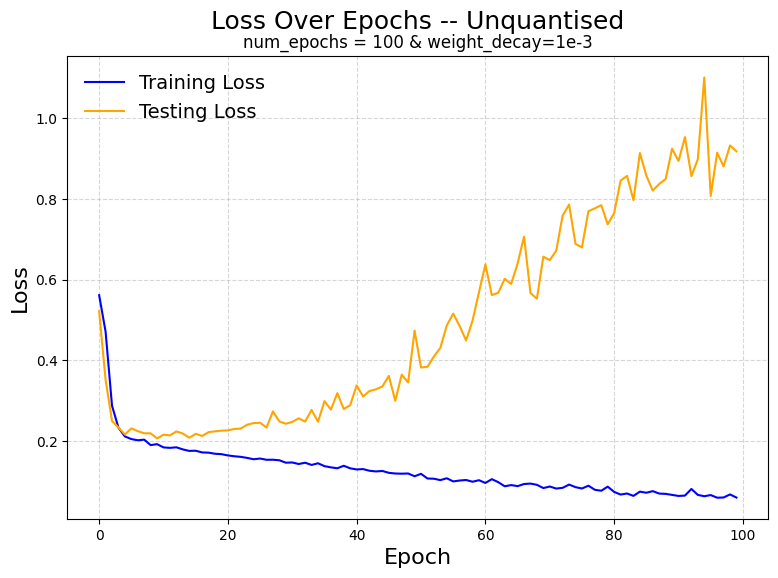

In [24]:
plot_loss(train_losses1, test_losses1, subtitle='num_epochs = 100 & weight_decay=1e-3', model_name= "Unquantised")

In [25]:
T1, acc1 = evaluate_model(model1, test_loader)

Accuracy: 0.6225833333333334
Predict time: 0.19550466537475586


In [26]:
# save 
np.save("T1.npy", T1)
T1 = np.load("T1.npy")

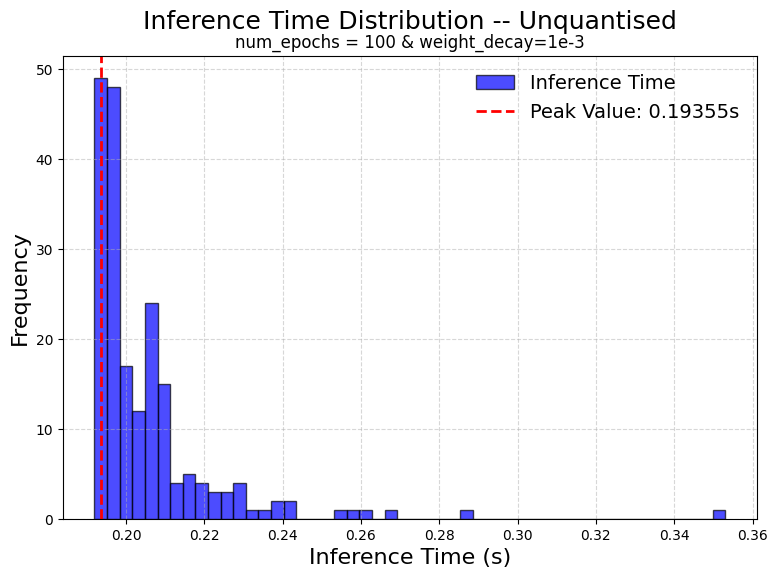

In [27]:
plot_time(T1, subtitle="num_epochs = 100 & weight_decay=1e-3", model_name= "Unquantised")

# QAT Model

## 40 epoches

In [11]:
num_epochs = 40
layers = [1024, 512, 128]
lr = 0.001

In [12]:
class BinaryClassificationModelQ(nn.Module):
    def __init__(self):
        super(BinaryClassificationModelQ, self).__init__()
        self.quant = torch.quantization.QuantStub()
        self.layer0 = nn.Linear(X.shape[1], layers[0])
        self.layer1 = nn.Linear(layers[0], layers[1])
        self.layer2 = nn.Linear(layers[1], layers[2])
        self.layer3 = nn.Linear(layers[2], 1)
        self.sigmoid = nn.Sigmoid()
        self.dequant = torch.quantization.DeQuantStub()
    
    def forward(self, x):
        timings = {}
        
        start_time = time.time()
        x = self.quant(x)
        timings['quant_time'] = time.time() - start_time

        start_time = time.time()
        x = torch.relu(self.layer0(x))
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        timings['fc_time'] = time.time() - start_time

        start_time = time.time()
        x = self.sigmoid(self.layer3(x))
        x = self.dequant(x)
        timings['dequant_time'] = time.time() - start_time

        return x, timings['quant_time'], timings['fc_time'], timings['dequant_time']

modelQ = BinaryClassificationModelQ()
modelQ.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
torch.quantization.prepare_qat(modelQ, inplace=True)


/home/codespace/.local/lib/python3.10/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


BinaryClassificationModelQ(
  (quant): QuantStub(
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
      (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
    )
  )
  (layer0): Linear(
    in_features=140, out_features=1024, bias=True
    (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_symmetric, reduce_range=False
      (activation_post_process): MovingAveragePerChannelMinMaxObserver(min_val=tensor([]), max_val=tensor([]))
    )
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_e

In [13]:
def train_model_qat(model, train_loader, test_loader, lr, num_epochs):
    model.train()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    train_losses = []
    test_losses = []
    timing = {'quant_time': 0, 'fc_time': 0, 'dequant_time': 0}

    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        epoch_train_loss = 0
        epoch_test_loss = 0

        # Training loop
        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            optimizer.zero_grad()
            outputs, quant_time, fc_time, dequant_time = model(inputs)
            
            # Accumulate the timing information
            timing['quant_time'] += quant_time
            timing['fc_time'] += fc_time
            timing['dequant_time'] += dequant_time

            # Compute training loss
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
            
        # Compute average training loss
        train_losses.append(epoch_train_loss / len(train_loader))
        # print(f"Epoch {epoch+1}, Train Loss: {epoch_train_loss / len(train_loader)}")

        # Evaluation loop on test set
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc="Testing", leave=False):
                outputs, _, _, _ = model(inputs)
                test_loss = criterion(outputs.squeeze(), labels.float())
                epoch_test_loss += test_loss.item()
        
        # Compute average test loss
        test_losses.append(epoch_test_loss / len(test_loader))
        # print(f"Epoch {epoch+1}, Test Loss: {epoch_test_loss / len(test_loader)}")

        model.train()  # Set model back to training mode

    return train_losses, test_losses, timing, model              

In [14]:
# Train the model
train_losses_qat, test_losses_qat, timing_qat, model_qat = train_model_qat(modelQ, train_loader, test_loader, lr, num_epochs)

Epochs: 100%|██████████| 40/40 [03:08<00:00,  4.71s/it]


In [15]:
np.save("train_losses_qat.npy", train_losses_qat)
np.save("test_losses_qat.npy", test_losses_qat)

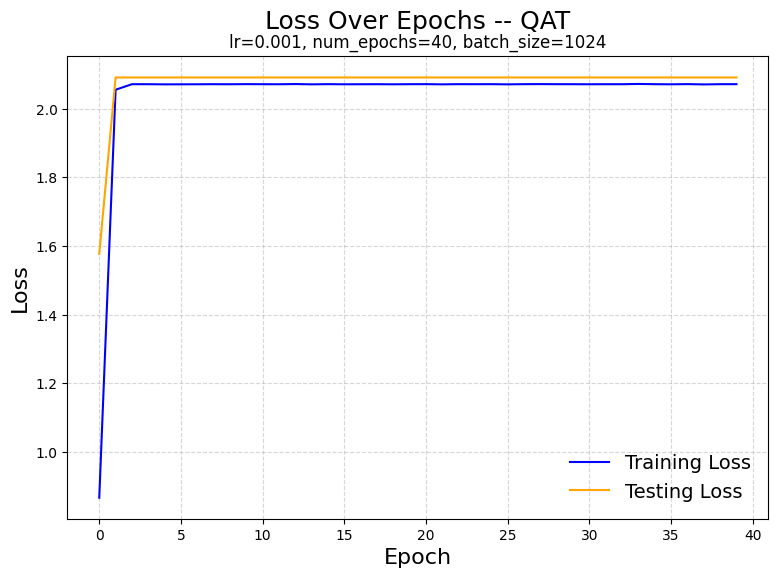

<Figure size 640x480 with 0 Axes>

In [22]:
# plot the loss
plot_loss(train_losses_qat, test_losses_qat, subtitle='lr=0.001, num_epochs=40, batch_size=1024', model_name= "QAT")
# save the image
plt.savefig("QAT_loss.pdf", dpi=300)

In [17]:
# save the model
torch.save(model_qat.state_dict(), 'model_qat.pth')

In [35]:
# # load the model 
# model_qat = BinaryClassificationModelQ()
# model_qat.load_state_dict(torch.load('model_qat.pth'))

RuntimeError: Error(s) in loading state_dict for BinaryClassificationModelQ:
	Unexpected key(s) in state_dict: "quant.activation_post_process.fake_quant_enabled", "quant.activation_post_process.observer_enabled", "quant.activation_post_process.scale", "quant.activation_post_process.zero_point", "quant.activation_post_process.activation_post_process.eps", "quant.activation_post_process.activation_post_process.min_val", "quant.activation_post_process.activation_post_process.max_val", "layer0.weight_fake_quant.fake_quant_enabled", "layer0.weight_fake_quant.observer_enabled", "layer0.weight_fake_quant.scale", "layer0.weight_fake_quant.zero_point", "layer0.weight_fake_quant.activation_post_process.eps", "layer0.weight_fake_quant.activation_post_process.min_val", "layer0.weight_fake_quant.activation_post_process.max_val", "layer0.activation_post_process.fake_quant_enabled", "layer0.activation_post_process.observer_enabled", "layer0.activation_post_process.scale", "layer0.activation_post_process.zero_point", "layer0.activation_post_process.activation_post_process.eps", "layer0.activation_post_process.activation_post_process.min_val", "layer0.activation_post_process.activation_post_process.max_val", "layer1.weight_fake_quant.fake_quant_enabled", "layer1.weight_fake_quant.observer_enabled", "layer1.weight_fake_quant.scale", "layer1.weight_fake_quant.zero_point", "layer1.weight_fake_quant.activation_post_process.eps", "layer1.weight_fake_quant.activation_post_process.min_val", "layer1.weight_fake_quant.activation_post_process.max_val", "layer1.activation_post_process.fake_quant_enabled", "layer1.activation_post_process.observer_enabled", "layer1.activation_post_process.scale", "layer1.activation_post_process.zero_point", "layer1.activation_post_process.activation_post_process.eps", "layer1.activation_post_process.activation_post_process.min_val", "layer1.activation_post_process.activation_post_process.max_val", "layer2.weight_fake_quant.fake_quant_enabled", "layer2.weight_fake_quant.observer_enabled", "layer2.weight_fake_quant.scale", "layer2.weight_fake_quant.zero_point", "layer2.weight_fake_quant.activation_post_process.eps", "layer2.weight_fake_quant.activation_post_process.min_val", "layer2.weight_fake_quant.activation_post_process.max_val", "layer2.activation_post_process.fake_quant_enabled", "layer2.activation_post_process.observer_enabled", "layer2.activation_post_process.scale", "layer2.activation_post_process.zero_point", "layer2.activation_post_process.activation_post_process.eps", "layer2.activation_post_process.activation_post_process.min_val", "layer2.activation_post_process.activation_post_process.max_val", "layer3.weight_fake_quant.fake_quant_enabled", "layer3.weight_fake_quant.observer_enabled", "layer3.weight_fake_quant.scale", "layer3.weight_fake_quant.zero_point", "layer3.weight_fake_quant.activation_post_process.eps", "layer3.weight_fake_quant.activation_post_process.min_val", "layer3.weight_fake_quant.activation_post_process.max_val", "layer3.activation_post_process.fake_quant_enabled", "layer3.activation_post_process.observer_enabled", "layer3.activation_post_process.scale", "layer3.activation_post_process.zero_point", "layer3.activation_post_process.activation_post_process.eps", "layer3.activation_post_process.activation_post_process.min_val", "layer3.activation_post_process.activation_post_process.max_val", "sigmoid.activation_post_process.fake_quant_enabled", "sigmoid.activation_post_process.observer_enabled", "sigmoid.activation_post_process.scale", "sigmoid.activation_post_process.zero_point", "sigmoid.activation_post_process.activation_post_process.scale", "sigmoid.activation_post_process.activation_post_process.zero_point". 

In [18]:
model_qat.eval()
y_pre = []
T_qat = []
for _ in range(200):
    times = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            stt= time.time()
            outputs, _, _, _ = model_qat(inputs)
            ent = time.time()
            times+=ent-stt
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pre.append(predicted)
        T_qat.append(times)
T_qat= np.array(T_qat)
accuracy0 = correct / total

print(f'Accuracy: {accuracy0}')
print(f'Predict time: {times}')

Accuracy: 0.62325
Predict time: 0.5192735195159912


In [19]:
np.save("T_qat.npy", T_qat)

In [20]:
T_qat = np.load("T_qat.npy")

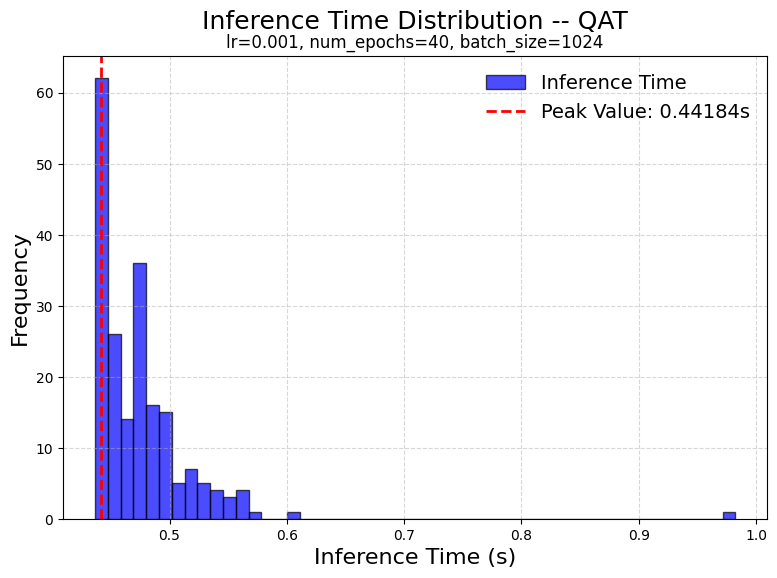

In [21]:
plot_time(T_qat, subtitle='lr=0.001, num_epochs=40, batch_size=1024', model_name="QAT")

In [42]:
def AUC(model,test_loader):
    model.eval()
    y_pre = []
    y_labe = []
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            outputs, _, _, _ = model(inputs)
            y_pre=np.append(y_pre,outputs.numpy())
            y_labe=np.append(y_labe,labels.numpy())
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(y_labe, y_pre)
    print(f'AUC = {auc}')

In [43]:
AUC(model_qat, test_loader)

AUC = 0.4999331461425324


### increase the number of epochs to 200

In [11]:
# Train the model
modelQ1 = BinaryClassificationModelQ()
modelQ1.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
torch.quantization.prepare_qat(modelQ1, inplace=True)

train_losses_1, test_losses_1, timing_1, model_qat_1 = train_model_qat(modelQ1, train_loader, test_loader, lr, num_epochs=200)

Epochs: 100%|██████████| 200/200 [19:48<00:00,  5.94s/it]


In [12]:
# save the model
torch.save(model_qat_1.state_dict(), 'model_qat_1.pth')

In [45]:
model_qat_1 = BinaryClassificationModelQ()
model_qat_1.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
torch.quantization.prepare_qat(model_qat_1, inplace=True)
model_qat_1.load_state_dict(torch.load("model_qat_1.pth"))

/home/codespace/.local/lib/python3.10/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


<All keys matched successfully>

In [14]:
np.save("train_losses_1.npy", train_losses_1)
np.save("test_losses_1.npy", test_losses_1)

In [23]:
train_losses_1 = np.load("train_losses_1.npy")
test_losses_1 = np.load("test_losses_1.npy")

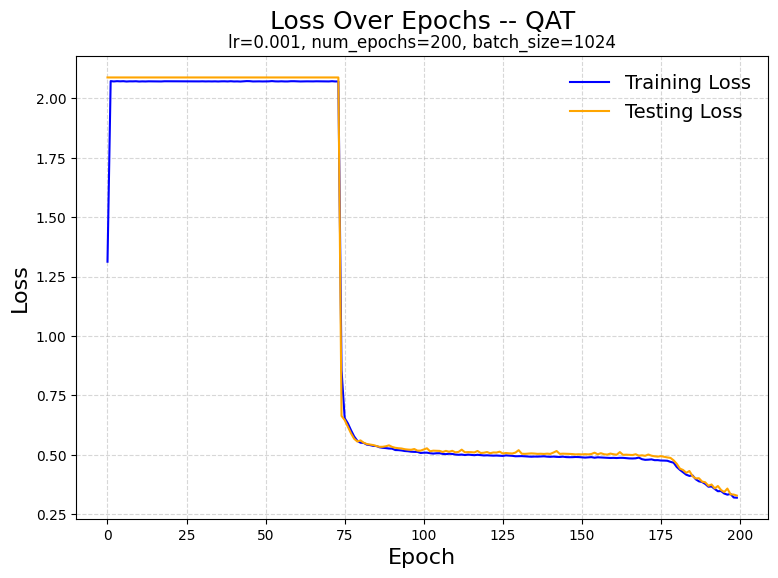

In [24]:
# plot the loss
plot_loss(train_losses_1, test_losses_1, subtitle='lr=0.001, num_epochs=200, batch_size=1024', model_name= "QAT")

In [17]:
# save the image
plt.savefig("QAT_loss_200.pdf", dpi=300)

<Figure size 640x480 with 0 Axes>

In [18]:
model_qat_1.eval()
y_pre = []
T_qat1 = []
for _ in range(200):
    times = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            stt= time.time()
            outputs, _, _, _ = model_qat_1(inputs)
            ent = time.time()
            times+=ent-stt
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pre.append(predicted)
        T_qat1.append(times)
T_qat1= np.array(T_qat1)
accuracy0 = correct / total

print(f'Accuracy: {accuracy0}')
print(f'Predict time: {times}')

Accuracy: 0.8634166666666667
Predict time: 0.6746265888214111


In [25]:
# np.save("T_qat1.npy", T_qat1)
T_qat1 = np.load("T_qat1.npy")

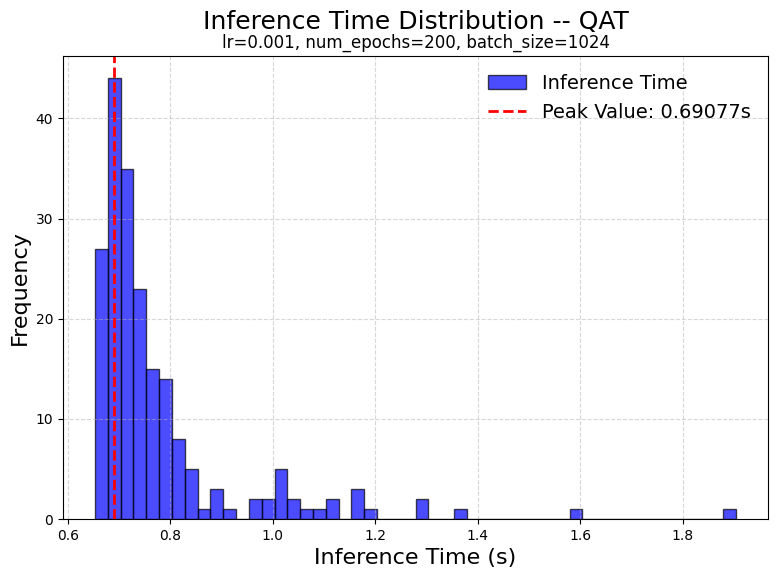

In [26]:
plot_time(T_qat1, subtitle='lr=0.001, num_epochs=200, batch_size=1024', model_name="QAT")

In [46]:
AUC(model_qat_1, test_loader)

AUC = 0.9339764257416895


### even larger epochs = 500

In [30]:
# Train the model
modelQ1 = BinaryClassificationModelQ()
modelQ1.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
torch.quantization.prepare_qat(modelQ1, inplace=True)

train_losses_2, test_losses_2, timing_2, model_qat_2 = train_model_qat(modelQ1, train_loader, test_loader, lr, num_epochs=500)

/home/codespace/.local/lib/python3.10/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Epochs: 100%|██████████| 500/500 [41:28<00:00,  4.98s/it]


In [31]:
# save the model
torch.save(model_qat_2.state_dict(), 'model_qat_2.pth')

In [ ]:
# model_qat_2 = BinaryClassificationModelQ()
# model_qat_2.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
# torch.quantization.prepare_qat(model_qat_2, inplace=True)
# model_qat_2.load_state_dict(torch.load("model_qat_2.pth"))

In [32]:
np.save("train_losses_2.npy", train_losses_2)
np.save("test_losses_2.npy", test_losses_2)

In [33]:
train_losses_2 = np.load("train_losses_2.npy")
test_losses_2 = np.load("test_losses_2.npy")

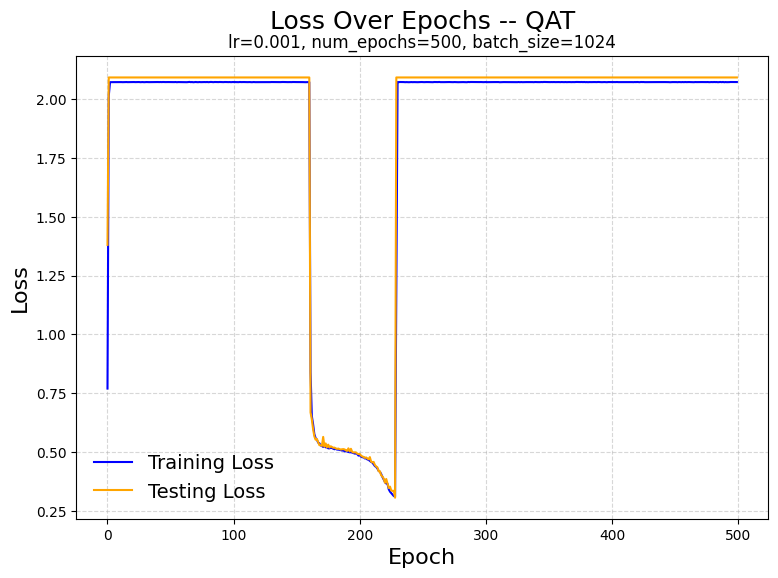

In [34]:
# plot the loss
plot_loss(train_losses_2, test_losses_2, subtitle='lr=0.001, num_epochs=500, batch_size=1024', model_name= "QAT")

In [35]:
model_qat_2.eval()
y_pre = []
T_qat2 = []
for _ in range(200):
    times = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            stt= time.time()
            outputs, _, _, _ = model_qat_2(inputs)
            ent = time.time()
            times+=ent-stt
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pre.append(predicted)
        T_qat2.append(times)
T_qat2= np.array(T_qat2)
accuracy0 = correct / total

print(f'Accuracy: {accuracy0}')
print(f'Predict time: {times}')

Accuracy: 0.62325
Predict time: 0.5355761051177979


In [36]:
np.save("T_qat2.npy", T_qat2)
T_qat2 = np.load("T_qat2.npy")

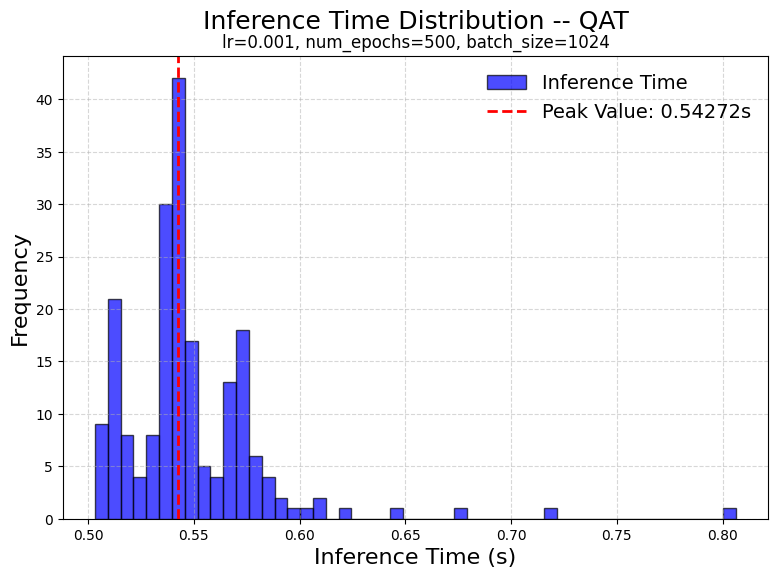

In [37]:
plot_time(T_qat2, subtitle='lr=0.001, num_epochs=500, batch_size=1024', model_name="QAT")

In [64]:

# # Train the model
# modelQ2 = BinaryClassificationModelQ()
# modelQ2.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
# torch.quantization.prepare_qat(modelQ2, inplace=True)

# train_losses_2, test_losses_2, timing_2, model_qat_2 = train_model_qat(modelQ2, train_loader, test_loader, lr, num_epochs=500)

/home/codespace/.local/lib/python3.10/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
Epochs: 100%|██████████| 500/500 [58:19<00:00,  7.00s/it]


In [34]:

# Train the model
modelQL = BinaryClassificationModelQ()
modelQL.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
torch.quantization.prepare_qat(modelQL, inplace=True)

train_losses_L, test_losses_L, timing_L, model_qat_L = train_model_qat(modelQL, train_loaderL, test_loaderL, lr, num_epochs=400)

/home/codespace/.local/lib/python3.10/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
Epochs: 100%|██████████| 400/400 [33:54<00:00,  5.09s/it]


In [35]:
# save the model
torch.save(model_qat_L.state_dict(), 'model_qat_L.pth')

In [47]:
model_qat_L = BinaryClassificationModelQ()
model_qat_L.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
torch.quantization.prepare_qat(model_qat_L, inplace=True)
model_qat_L.load_state_dict(torch.load("model_qat_L.pth"))

/home/codespace/.local/lib/python3.10/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


<All keys matched successfully>

In [48]:
AUC(model_qat_L, test_loader)

AUC = 0.9554731867528867


In [36]:
np.save("train_losses_L.npy", train_losses_L)
np.save("test_losses_L.npy", test_losses_L)

In [38]:
train_losses_L = np.load("train_losses_L.npy")
test_losses_L = np.load("test_losses_L.npy")

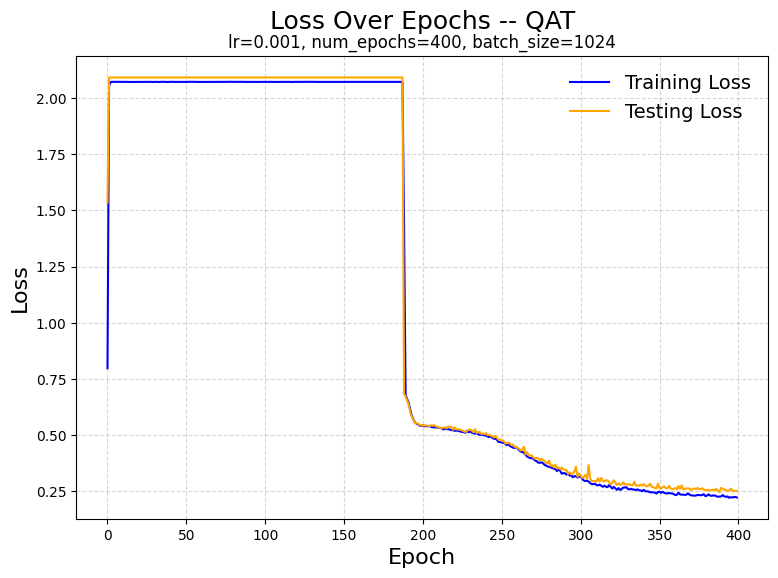

In [39]:
plot_loss(train_losses_L, test_losses_L, subtitle='lr=0.001, num_epochs=400, batch_size=1024', model_name= "QAT")

In [39]:
model_qat_L.eval()
y_pre = []
T_qatL = []
for _ in range(200):
    times = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loaderL:
            stt= time.time()
            outputs, _, _, _ = model_qat_L(inputs)
            ent = time.time()
            times+=ent-stt
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pre.append(predicted)
        T_qatL.append(times)
T_qatL= np.array(T_qatL)
accuracy0 = correct / total

print(f'Accuracy: {accuracy0}')
print(f'Predict time: {times}')

Accuracy: 0.9050833333333334
Predict time: 0.5231294631958008


In [40]:
# np.save("T_qatL.npy", T_qatL)
T_qatL = np.load("T_qatL.npy")

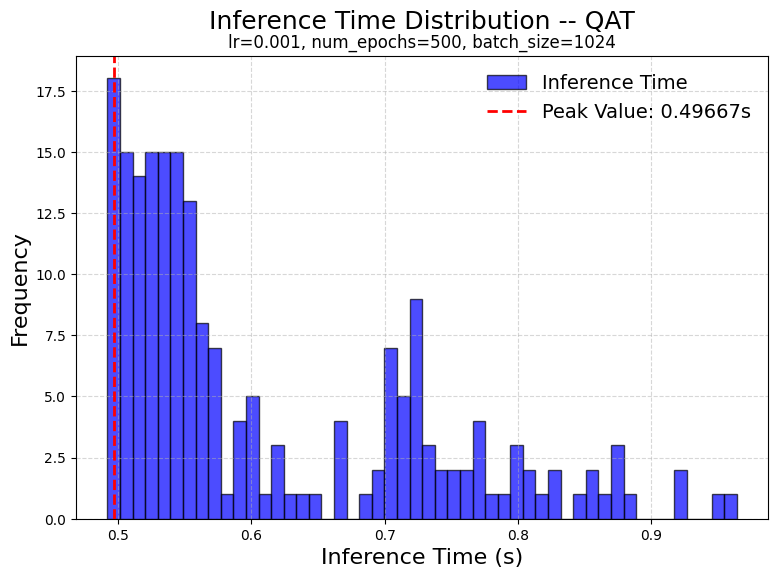

In [41]:
plot_time(T_qatL, subtitle='lr=0.001, num_epochs=500, batch_size=1024', model_name="QAT")

In [ ]:
# Save T:
np.save('T_qatL.npy', T_qatL)

# PTQ

In [ ]:
# loaded the trained original model
model_ptq = BinaryClassificationModel()
model_ptq.load_state_dict(torch.load("model.pth"))

In [ ]:
# apply the qunatisation
model_ptq.eval()
quantized_model = torch.quantization.quantize_dynamic(
    model_ptq,  
    {nn.Linear},  
    dtype=torch.qint8
)
quantized_model.eval()
QT = []

In [ ]:
quantized_model.eval()
y_pre = []
QT = []
for _ in range(200):
    times = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            stt= time.time()
            outputs, _ = quantized_model(inputs)
            ent = time.time()
            times+=ent-stt
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pre.append(predicted)
        QT.append(times)
QT= np.array(QT)
accuracy0 = correct / total

print(f'Accuracy: {accuracy0}')
print(f'Predict time: {times}')

In [ ]:
# Plot the histogram
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
n, bins, patches = plt.hist(QT, bins=50, density=False, alpha=0.7, color='blue', label='PTQ')  # Adjust alpha for transparency

# Find the peak value
peak_value = np.max(n)
peak_index = np.argmax(n)
peak_bin_center = (bins[peak_index] + bins[peak_index + 1]) / 2

# Plot vertical line at peak value
plt.axvline(x=peak_bin_center, color='red', linestyle='--', linewidth=2, label='Peak Value: {:.2f}'.format(peak_bin_center))

# Set title, labels, legend, and grid
plt.title('Inference Time Distribution -- Large Model', fontsize=16)  # Increase font size for better readability
plt.xlabel('Time (s)', fontsize=14)  # Increase font size for better readability
plt.ylabel('Frequency', fontsize=14)  # Increase font size for better readability
plt.legend(fontsize=12)  # Increase font size for better readability
plt.grid(True, linestyle='--', alpha=0.5)  # Add grid lines for better readability
plt.tight_layout()  # Adjust subplot parameters to give specified padding

# Save figure
plt.savefig('inference_time_distribution_with_peak_PTQ.pdf', dpi=300)  # Save figure with higher resolution for publication

plt.show()

In [ ]:
np.save("QT.npy", QT)

# COMbine\?


In [49]:
model_qat_ptq = BinaryClassificationModelQ()
model_qat_ptq.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
torch.quantization.prepare_qat(model_qat_ptq, inplace=True)
model_qat_ptq.load_state_dict(torch.load("model_qat_L.pth"))

/home/codespace/.local/lib/python3.10/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


<All keys matched successfully>

In [50]:
model_qat_ptq.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
torch.quantization.prepare_qat(model_qat_ptq, inplace=True)

BinaryClassificationModelQ(
  (quant): QuantStub(
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([0.3068]), zero_point=tensor([27], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
      (activation_post_process): MovingAverageMinMaxObserver(min_val=-8.310100555419922, max_val=30.652925491333008)
    )
  )
  (layer0): Linear(
    in_features=140, out_features=1024, bias=True
    (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.0000e-01, 1.0000e-01, 1.0000e-01,  ..., 6.1000e-05, 1.0000e-01,
              1.0000e-01]), zero_point=tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_symmetric, reduce_range=False
      (activation_post_process): MovingAveragePerChann

In [54]:
model_qat_ptq.eval()
quantized_model = torch.quantization.quantize_dynamic(
    model_qat_ptq,  
    {nn.Linear},  
    dtype=torch.qint8
)
quantized_model.eval()

/home/codespace/.local/lib/python3.10/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


AttributeError: 'FusedMovingAvgObsFakeQuantize' object has no attribute 'activation_post_process'

In [51]:
AUC(model_qat_ptq, test_loader)

AUC = 0.9564002387396942


In [52]:
model_qat_ptq.eval()
y_pre = []
QQT = []
for _ in range(200):
    times = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            stt= time.time()
            outputs, _, _, _ = model_qat_ptq(inputs)
            ent = time.time()
            times+=ent-stt
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pre.append(predicted)
        QQT.append(times)
QQT= np.array(QQT)
accuracy0 = correct / total

print(f'Accuracy: {accuracy0}')
print(f'Predict time: {times}')

Accuracy: 0.9065
Predict time: 0.6795663833618164


In [ ]:
# save the T
np.save("QQT.npy", QQT)

In [ ]:
QQT = np.load("QQT.npy")

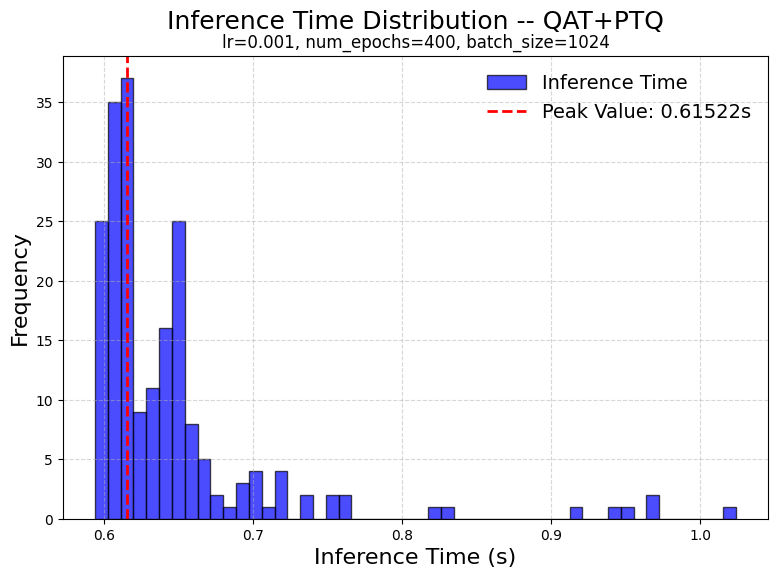

In [53]:
plot_time(QQT, subtitle="lr=0.001, num_epochs=400, batch_size=1024",  model_name= "QAT+PTQ")